# __Step 7.5: Topic per country__

Goal:
- Plot overall pub volume in plant science per country
- Plot relative volume
- Plot relative pub volume over time

Additional analyses:
- Plant sci pub #
- Per country
- Noramlized against subset of [UNESCO](https://apiportal.uis.unesco.org/bdds) data
  - Education
    - `SDG` Global and Thematic Indicators
    - `OPRI` Other Policy Relevant Indicators
  - Science (SCN)
    - `SCN-SDG` Research and Development (R&D) SDG 9.5
    - `SCN-OPRI` Research and Development (R&D) – Other Policy Relevant Indicators
  - Culture
    - `SDG11` SDG 11.4
  - External
    - `DEM` Demographic and Socio-economic Indicators
  - Focus on:
    - Total population
    - GDP total
    - GDP per capita
    - Researcher number
    - Gross domestic expenditure on R&D (GERD) as percent GDP 


Observations
- Top 25 country
- Top 10 normalized by country total
  - Meterological rise of China, major contributor to the exponential growth in plant science lit.
  - Strong upward trend of India
  - Strong upward trend 
  - Slow growth in the other top 8 countries, including a few that are stagnant in the last 20 years. 

Resources:
- [Best Libraries for Geospatial Data Visualisation in Python](https://towardsdatascience.com/best-libraries-for-geospatial-data-visualisation-in-python-d23834173b35)
- [Plotly documentation](https://plotly.com/python/)
- [Interactive map in python](https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-raster-plots/interactive-maps/)
- [Analysing and Visualising the Country wise Population from 1955 to 2020 with Pandas, Matplotlib, Seaborn and Plotly](https://towardsdatascience.com/analysing-and-visualising-the-country-wise-population-from-1955-to-2020-with-pandas-matplotlib-70b3614eed6b)
- [How to plot and color world map based on data](https://medium.com/@petrica.leuca/how-to-plot-and-color-world-map-based-on-data-c367e4cda7d9)

## ___Setup___

### Module import

In conda env `base`

In [75]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from scipy.stats import fisher_exact
from math import log

# for biclustering
from sklearn.cluster import SpectralCoclustering
from sklearn.datasets import make_biclusters
from sklearn.metrics import consensus_score

### Key variables

In [5]:
# Reproducibility
seed = 20220609

# Setting working directory
proj_dir   = Path.home() / "projects/plant_sci_hist"
work_dir   = proj_dir / "7_countries/7_5_country_over_time"
work_dir.mkdir(parents=True, exist_ok=True)

# plant science corpus with topic assignment info
dir42      = proj_dir / "4_topic_model/4_2_outlier_assign"
corpus_file = dir42 / "table4_2_corpus_with_topic_assignment.tsv.gz"
#corpus_file = dir42 / "test.tsv"

# timestamp bins
dir44            = proj_dir / "4_topic_model/4_4_over_time"
ts_for_bins_file = dir44 / "table4_4_bin_timestamp_date.tsv"
file_topic_name   = dir44 / "fig4_4_tot_heatmap_weighted_xscaled_names.txt"

# country data
dir74            = proj_dir / "7_countries/7_4_consolidate_all"
ci_file          = dir74 / 'country_info_final_a3.txt'

# unesco data dir
unesco_dir       = work_dir / 'unesco'

# So PDF is saved in a format properly
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.family"] = "sans-serif"

## ___Topic assignment___

### Read topic assignment

Lifted from script_5_3

In [6]:
# topic data-frame
tdf = pd.read_csv(corpus_file, sep='\t', compression='gzip', index_col=[0])

print("topic dataframe:", tdf.shape)

topic dataframe: (421658, 12)


In [7]:
tdf.head(2)

,Index_1385417,PMID,Date,Journal,Title,Abstract,Initial filter qualifier,Corpus,reg_article,Text classification score,Preprocessed corpus,Topic
0,3,61,1975-12-11,Biochimica et biophysica acta,Identification of the 120 mus phase in the dec...,After a 500 mus laser flash a 120 mus phase in...,spinach,Identification of the 120 mus phase in the dec...,1,0.716394,identification 120 mus phase decay delayed flu...,52
1,4,67,1975-11-20,Biochimica et biophysica acta,Cholinesterases from plant tissues. VI. Prelim...,Enzymes capable of hydrolyzing esters of thioc...,plant,Cholinesterases from plant tissues. VI. Prelim...,1,0.894874,cholinesterases plant tissues . vi . prelimina...,48


In [8]:
# Found that the original dataframe has some duplicated PMIDs
tdf.duplicated(subset=['PMID']).sum()

351

In [9]:
duplicated = tdf[tdf.duplicated(subset=['PMID'])]['PMID'].values
for pmid in duplicated:
    print(tdf[tdf['PMID'] == pmid][['PMID', 'Topic']])

            PMID  Topic
237916  24358894     -1
243715  24358894     35
            PMID  Topic
243717  24555064     51
243962  24555064     51
            PMID  Topic
254554  25165534     83
254742  25165534     83
            PMID  Topic
263498  25653837     23
263687  25653837     23
            PMID  Topic
308523  28232862     74
313258  28232862     74
            PMID  Topic
275391  26309725      6
329893  26309725      6
            PMID  Topic
329667  29188023     16
336639  29188023     16
            PMID  Topic
336707  29560253     55
337976  29560253     55
            PMID  Topic
325000  28928963     60
339161  28928963     60
            PMID  Topic
339625  29721312     72
339875  29721312     72
            PMID  Topic
371175  31031972     27
371798  31031972     27
            PMID  Topic
336119  29528046     59
381910  29528046     59
            PMID  Topic
383683  31633057     -1
387955  31633057     -1
            PMID  Topic
399763  32399197     60
399981  32399197

In [10]:
# rid of duplicated entries
tdf_nodup = tdf.drop_duplicates(subset=['PMID'])
tdf_nodup.to_csv(dir42 / 'table7_5_corpus_with_topic_assignment_nodup.tsv.gz', 
                 sep='\t', compression='gzip')
tdf_nodup.shape

(421307, 12)

### Get pmid, date, and topic

Code lifted from 4.4

In [11]:
# Create pmid-topic dataframe
pmid_topic = tdf_nodup[['PMID', 'Date', 'Topic']]
pmid_topic.head(2)

,PMID,Date,Topic
0,61,1975-12-11,52
1,67,1975-11-20,48


### Get topc indices and names

In [12]:
# topic assignments
toc_array = tdf_nodup['Topic'].values

# topic indices
tocs = np.unique(toc_array)

# exclude topic=-1
tocs_90 = tocs[1:]

# number of topic=-1
n_rec_toc_unassigned = sum((toc_array==-1).astype(int))

# number of docs with topic assignment. Originally was thinking about minus
# unassigned, but realize that the totol for taxa would be the number of total
# docs, so it does not make sense to remove unassigned.
n_rec_total  = len(toc_array)

print("number of topic=-1:", n_rec_toc_unassigned)
print("number of docs with topic assignment:", n_rec_total)

number of topic=-1: 49192
number of docs with topic assignment: 421307


### Read topic names

In [13]:

toc_names = pd.read_csv(file_topic_name, sep='\t')
toc_names.head(2)

,Topic,Mod_name
0,22,enzyme | fatty acids | lipid | synthesis
1,18,protein | dna | rna | synthesis | mrna


## ___Process country data___




### Country data

In [14]:
ci = pd.read_csv(ci_file, sep='\t')
ci.shape

(330328, 3)

In [15]:
ci.head()

,PMID,A3,Confidence
0,400957,CAN,3
1,1279107,FRA,3
2,1279650,JPN,3
3,1280064,BRA,3
4,1280162,JPN,3


In [16]:
ci.duplicated(subset=['PMID']).sum()

0

### Join country data with pmid_topic

https://sparkbyexamples.com/pandas/pandas-join-dataframes-on-columns/

In [17]:
ci_pmid_topic = pd.merge(ci, pmid_topic, on='PMID')
ci_pmid_topic.shape

(330328, 5)

In [18]:
ci_pmid_topic.head(2)

,PMID,A3,Confidence,Date,Topic
0,400957,CAN,3,1978-01-01,50
1,1279107,FRA,3,1992-11-01,12


### Add year column

In [19]:
year = [int(date.split('-')[0]) for date in ci_pmid_topic['Date'].values]
ci_pmid_topic['Year'] = year
ci_pmid_topic.to_csv(work_dir / 'ci_pmid_topic.tsv', sep='\t', index=False)
ci_pmid_topic.head(2)

,PMID,A3,Confidence,Date,Topic,Year
0,400957,CAN,3,1978-01-01,50,1978
1,1279107,FRA,3,1992-11-01,12,1992


## ___Country count___

### Raw counts

In [20]:
# Country list
clist = ci_pmid_topic['A3'].unique()
cn_dict = {} # {country: n_pub}
for c in clist:
  n_pubs = ci_pmid_topic[ci_pmid_topic['A3']==c].shape[0]
  cn_dict[c] = n_pubs

In [21]:
# output
cn_dict_sorted = {k: v for k, v in sorted(cn_dict.items(), 
                                          key=lambda item: item[1], 
                                          reverse=True)}
cn_dict_sorted_file = work_dir / 'country_npub_raw.csv'
c = 0; n_total25 = 0; top25 = []
with open(cn_dict_sorted_file, 'w') as f:
  f.write("country,n_pub\n")
  for k, v in cn_dict_sorted.items():
    f.write("%s,%s\n"%(k,v))
    if c < 25:
      print(k, v)
      n_total25 += v
      top25.append(k)
      c += 1

print("All others:", ci_pmid_topic.shape[0] - n_total25)

CHN 60298
USA 59503
JPN 23573
DEU 22720
FRA 15300
GBR 14593
IND 13388
ESP 12248
ITA 9775
AUS 9755
CAN 9256
BRA 7332
NLD 5668
POL 4422
CHE 4108
BEL 4004
SWE 3675
MEX 3298
ISR 3253
ARG 3232
DNK 2615
AUT 2330
TWN 2314
FIN 2311
CZE 2305
All others: 29052


### Common function

In [22]:
def get_indicator(fname):
  ufile = unesco_dir / fname
  df    = pd.read_csv(ufile, sep=',')
  return df['Indicator'].unique()

In [23]:
def normalize(fname, indicator, twn_val, cn_dict_sorted, outname, factor_name):
  '''
  Take UNESCO data and get the most recent indicator value to normalize pub
  counts.
  Args:
    fname: UNESCO data file name
    indicator: specific indicator to get
    twn_val: value for twn
    cn_dict_sorted: {country: n_pub}
    outname: output file name
    factor_name: name of the factor to normalize by
  Return:
    norm_dict: {country: n_pub/n_factor}
  '''
  ufile = unesco_dir / fname
  df    = pd.read_csv(ufile, sep=',')

  # Get total pop for 2020
  df20 = df[(df['Indicator'] == indicator) & (df['Time'] == 2020)]
  df20 = df20[['LOCATION', 'Time', 'Value']]
  df20.loc[len(df20)] = ['TWN', 2020, twn_val]

  # Get total pubs per country normalized by 2020 pop size
  a3s  = df20['LOCATION'].values
  vals = df20['Value'].values

  # iterate through countries
  norm_dict = {} # {country: n_pub/n_factor}
  for a3 in cn_dict_sorted:
    # Get total pubs per country
    n_pub = cn_dict_sorted[a3]
    
    # get the most recent indicator value
    df_a3 = df[(df['Indicator'] == indicator) & (df['LOCATION'] == a3)]
    if df_a3.shape[0] != 0:
      n_factor = df_a3.sort_values('Time', ascending=False)['Value'].iloc[0]
      norm_dict[a3] = n_pub/n_factor
    elif a3 == 'TWN':
      n_factor = twn_val
      norm_dict[a3] = n_pub/n_factor
    else:
      norm_dict[a3] = np.nan

  norm_sorted = {k: v for k, v in sorted(norm_dict.items(), 
                                         key=lambda item: item[1], 
                                         reverse=True)}

  outfile = work_dir / outname
  c = 0
  with open(outfile, 'w') as f:
    f.write(f"country,n_pub/{factor_name}\n")
    for k, v in norm_sorted.items():
      f.write("%s,%s\n"%(k,v))
      if c < 25:
        print(k, v)
        c += 1

  return norm_dict

### Total population

227 country has data in 2020
- This is not particularly informative.

In [24]:
# DEMO_IND, Indicator, LOCATION (a3 code), Country, TIME (year), time, Value, ..
cpop_file = 'DEMO_DS_13062023083742557-total_pop.csv'
get_indicator(cpop_file)

array(['Fertility rate, total (births per woman)',
       'Life expectancy at birth, total (years)',
       'Mortality rate, infant (per 1,000 live births)',
       'Population growth (annual %)',
       'Prevalence of HIV, total (% of population ages 15-49)',
       'Rural population (% of total population)',
       'Population aged 25-64 years (thousands) ',
       'Total population (thousands)',
       'Population aged 65 years or older (thousands)',
       'Population aged 14 years or younger (thousands)',
       'Population aged 15-24 years (thousands)'], dtype=object)

In [25]:
cpop_indi = 'Total population (thousands)'
cpop_out  = 'country_npub_norm_pop.csv'
cpop_dict = normalize(cpop_file, cpop_indi, 23600, cn_dict_sorted, cpop_out, 
                     "n_pop")

CHE 0.468201504444951
DNK 0.4481576692373608
FIN 0.416021602160216
AUS 0.37419924047719516
NZL 0.37239689669252757
ISR 0.36456348761627255
SWE 0.35962422937665134
BEL 0.34316078162495717
NLD 0.32932426936261694
DEU 0.2708502217347766
ESP 0.2621631456152743
EST 0.2586989409984871
AUT 0.2569758464762325
CAN 0.24111701573408356
FRA 0.23439654379998162
CZE 0.21467821551643848
GBR 0.21304271657566645
NOR 0.19814915623298857
SVN 0.1929740134744947
PRT 0.1903165368306873
JPN 0.18581901308529086
USA 0.18082445717411455
ITA 0.16220566516768167
IRL 0.10145808019441069
SGP 0.09606837606837607


### GDP per capita

In [26]:
# country GDP per capita
cgdp_file = 'DEMO_DS_13062023084002265-gdp_per_capita.csv'
get_indicator(cgdp_file)


array(['GDP (current LCU)', 'GDP (current US$)',
       'GDP deflator (base year varies by country)',
       'GDP growth (annual %)', 'GDP per capita (current US$)',
       'GDP per capita, PPP (current international $)',
       'GDP, PPP (current international $)',
       'General government total expenditure (current LCU)',
       'GNI per capita, Atlas method (current US$)',
       'GNI per capita, PPP (current international $)',
       'PPP conversion factor, GDP (LCU per international $)',
       'Total debt service (% of GNI)', 'GNI per capita (current LCU)',
       'GDP at market prices (constant 2010 US$)',
       'Price level ratio of PPP conversion factor (GDP) to market exchange rate',
       'GDP (constant LCU)',
       'Official exchange rate (LCU per US$, period average)',
       'DEC alternative conversion factor (LCU per US$)',
       'PPP conversion factor, private consumption (LCU per international $)',
       'GNI (current LCU)',
       'GDP per capita, PPP (constant

In [27]:
cgdp_indi = 'GDP per capita (current US$)'
cgdp_out  = 'country_npub_norm_gdppc_usd.csv'

# TWN data
cgdp_dict = normalize(cgdp_file, cgdp_indi, 32811, cn_dict_sorted, cgdp_out, 
                     "n_gdp_per_capita_ppp")

IND 5.931767833407178
CHN 4.8023255813953485
PAK 1.1029900332225913
BRA 0.9766884241374717
USA 0.8470298509587325
JPN 0.599623534199883
DEU 0.4437153347394735
ESP 0.4068562317300027
FRA 0.35044320758606473
MEX 0.32828986661357756
GBR 0.3137604816168566
ARG 0.3038736367055284
ITA 0.27413972011105814
ZAF 0.2581148121899362
POL 0.24566666666666667
EGY 0.24168694241686942
TUN 0.2353559232991857
NGA 0.2090997095837367
THA 0.19374469289555618
CAN 0.1780410864045549
AUS 0.16139172443459127
TUR 0.15133009005278958
ETH 0.14594594594594595
KEN 0.13112391930835735
PHL 0.11615140132909564


### Researcher per million inhabitants

In [28]:
rpmi_file = 'SCN_DS_13062023084130725-researcher_per_mil_inhabit.csv'
get_indicator(rpmi_file)

array(['Researchers per million inhabitants (FTE)',
       'GERD as a percentage of GDP'], dtype=object)

In [29]:
rpmi_indi = 'Researchers per million inhabitants (FTE)'
rpmi_out  = 'country_npub_norm_res_per_mil_inhabit.csv'

#https://www.statista.com/statistics/324708/taiwan-number-of-researchers-per-10000-population/
rpmi_twn  = 86.6/1e4*1e6 # <--- need to find info
# TWN data
rpmi_dict = normalize(rpmi_file, rpmi_indi, rpmi_twn, cn_dict_sorted, rpmi_out, 
                     "n_res_per_mil_inhabit")

IND 52.97899613112452
CHN 38.04614057086714
USA 12.341877716170323
COL 5.260221929104024
JPN 4.321607698048828
DEU 4.212754781874405
ESP 3.9392215930888814
AUS nan
BRA nan
MEX 9.456505551094923
ISR nan
PAK 3.925947826092715
ZAF 3.7602212042528618
ITA 3.6585348235363457
GBR 3.115655455562769
FRA 3.105849317881193
ARG 2.612997762329614
CHL 2.228060336892913
CAN 2.049463364314565
MYS 1.448494661709944
POL 1.3448219610216947
EGY 1.046495049282425
NLD 0.9587787716095254
SAU 0.9177359217882325
TUR 0.8235009553568641


### Gross domestic expenditure on R&D (GERD) as a percentage of GDP

In [30]:
gerd_indi = 'GERD as a percentage of GDP'
gerd_out  = 'country_npub_norm_gerd_per_capita.csv'
# https://www.ncses.nsf.gov/pubs/nsb20225/cross-national-comparisons-of-r-d-performance
gerd_twn  = 3.49
# TWN data
gerd_dict = normalize(rpmi_file, gerd_indi, gerd_twn, cn_dict_sorted, gerd_out, 
                     "n_gerd_gdp")

CHN 25054.640040554128
IND 20430.649025622242
USA 17383.94972639919
MEX 11127.606451177544
PAK 10095.481359849176
ESP 8684.122831273618
GBR 8479.815911349227
DEU 7307.11092528865
JPN 7198.741831063336
FRA 6518.488221986477
ITA 6399.764305355506
BRA 6282.5610090485325
ARG 6153.611819808842
CAN 5456.324644242446
AUS 5333.748879119918
CHL 3325.242008598251
POL 3191.650607366347
ZAF 2964.3496662868306
NLD 2459.535691039271
COL 1600.2488507932121
SAU 1385.0892876375935
TUR 1342.960023515579
NZL 1298.997265268915
CHE 1286.8787238974758
NGA nan


## ___Country pub counts over time___

### Number pub per country per year for top 25 countries

- Top 25 vs. all others
- After 1980 look at each year, <=1980 lumpped together

In [31]:
ci_pmid_topic.head(2)

,PMID,A3,Confidence,Date,Topic,Year
0,400957,CAN,3,1978-01-01,50,1978
1,1279107,FRA,3,1992-11-01,12,1992


In [32]:
a3_yr_count = {"all_others":{}} # {a3: {yr: count}}
for _, row in tqdm(ci_pmid_topic.iterrows(), total=ci_pmid_topic.shape[0]):
  a3 = row['A3']
  yr = row['Year']

  # alll years before 1980 is counted as 1980
  if yr < 1980:
    yr = 1980
  elif yr > 2020:
    yr = 2020

  # Focus on top 25 countries, the rest in all_others
  if a3 in top25:
    if a3 not in a3_yr_count:
      a3_yr_count[a3] = {yr:1}
    elif yr not in a3_yr_count[a3]:
      a3_yr_count[a3][yr] = 1
    else:
      a3_yr_count[a3][yr] += 1
  else:
    if yr not in a3_yr_count["all_others"]:
      a3_yr_count["all_others"][yr] = 1
    else:
      a3_yr_count["all_others"][yr] += 1

100%|██████████| 330328/330328 [00:07<00:00, 43707.06it/s]


In [33]:
# Geneerate output
a3_yr_count_file = work_dir / "country_top25_year_count.csv"
year_list        = list(range(1980, 2021))
with open(a3_yr_count_file, 'w') as f:
  # write header
  f.write(f"country,{','.join([str(yr) for yr in year_list])}\n")
  for a3 in a3_yr_count:
    count_list = []
    for yr in year_list:
      if yr not in a3_yr_count[a3]:
        a3_yr_count[a3][yr] = 0
      count_list.append(str(a3_yr_count[a3][yr]))
    f.write(f"{a3},{','.join(count_list)}\n")


## ___Country representation among topics___

### Enrichment of topics per top 10 country

From 5.3.

|                 | In topic T | Not in topic T |
|    ---          | ---        | ---            |
|In country X     | a          | b              |
|Not in country X | c          | d              |


In [34]:
def fet(a, b, c, d):
  res = fisher_exact([[a, b],[c, d]], alternative='two-sided')
  return res

In [48]:
def get_top_country_fet(top=10):
  '''For each countr, each topic, get FET
  Args:
    top: top X countries
  Return:
    c_toc_stat: {a3: {toc:[LLR, p-value]}}
  '''
  topX       = top25[:top]
  c_toc_stat = {} # {a3: {toc:[LLR, p-value]}}
  for toc in tqdm(tocs_90):
    inT = (ci_pmid_topic['Topic'] == toc)
    for a3 in topX:
      inC   = (ci_pmid_topic['A3'] == a3)
      a     = ci_pmid_topic[ inT &  inC].shape[0]
      b     = ci_pmid_topic[ inT & ~inC].shape[0]
      c     = ci_pmid_topic[~inT &  inC].shape[0]
      d     = ci_pmid_topic[~inT & ~inC].shape[0]
      # Get stat and p-value
      [_,p] = fet(a, b, c, d)
      try:
        llr = log((a/b)/(c/d),2)
      except ValueError:
        llr = np.nan
      
      if a3 not in c_toc_stat:
        c_toc_stat[a3] = {toc:[llr, p]}
      elif toc not in c_toc_stat[a3]:
        c_toc_stat[a3][toc] = [llr, p]
      else:
        pass

  return c_toc_stat

In [63]:
def generate_output(c_toc_stat, otype):
  '''
  Args:
    c_to_stat (dict): from get_top_country_fet()
    otype (str): "stat" or "pval"
  Output:
    country_top{top}_toc_stat.csv: topic as rows, country as columns, stat or 
      pval as values
  '''
  # write stat
  top = len(c_toc_stat)
  c_toc_stat_file = work_dir / f"country_top{top}_toc_{otype}.csv"
  if otype == "stat":
    oidx = 0
  elif otype == "pval":
    oidx = 1
  else:
    print("ERR: unknown otype", otype)
    return 0
  
  with open(c_toc_stat_file, "w") as f:
    # write header
    f.write(f"toc,toc_name,{','.join([c for c in c_toc_stat])}\n")
    for idx, toc in enumerate(tocs_90):
      toc_name = toc_name_list[idx]
      stat_list = []
      for a3 in c_toc_stat:
        stat_list.append(str(c_toc_stat[a3][toc][oidx]))
      f.write(f"{toc},{toc_name},{','.join(stat_list)}\n")

In [50]:
c25_toc_stat = get_top_country_fet(25)

100%|██████████| 90/90 [00:46<00:00,  1.93it/s]


In [51]:
c10_toc_stat = get_top_country_fet(10)

100%|██████████| 90/90 [00:18<00:00,  4.87it/s]


In [65]:
# Get country names
toc_name_list = []
for toc in tocs_90: 
  toc_name_list.append(toc_names[toc_names["Topic"]==toc]['Mod_name'].values[0])

In [67]:
generate_output(c25_toc_stat, "stat")
generate_output(c25_toc_stat, "pval")
generate_output(c10_toc_stat, "stat")
generate_output(c10_toc_stat, "pval")

### Biclustering

https://scikit-learn.org/stable/modules/biclustering.html

In [72]:
c25_toc_stat_file = work_dir / "country_top25_toc_stat.csv"
c25_toc_stat_df   = pd.read_csv(c25_toc_stat_file, index_col=0)

In [73]:
c25_toc_stat_df.head(2)

,toc_name,CHN,USA,JPN,DEU,FRA,GBR,IND,ESP,ITA,...,BEL,SWE,MEX,ISR,ARG,DNK,AUT,TWN,FIN,CZE
toc,,,,,,,,,,,,,,,,,,,,,
0,allergen | pollen | ige | allergenic,-3.312153,-1.542355,-0.055263,1.198622,-0.706536,-1.728808,-0.129337,2.473362,1.282652,...,-1.566289,1.005351,-1.870480,NaN,-1.841007,1.407829,4.874546,-1.354562,0.663111,NaN
1,medium | callus | regeneration | culture | som...,-1.242767,-0.361898,0.070518,-1.373959,-0.198650,-0.394981,2.660110,-0.503193,-0.559371,...,-0.884021,-1.501572,0.147972,-0.680384,0.446187,-1.175619,-1.689199,0.479973,-0.405347,-1.996689


## ___Test___

### Deprecated

In [ ]:
def get_df20(fname, indicator, twn_val, cn_dict_sorted, outname, factor_name):
  '''Take UNESCO data and get the most recent indicator value.
  Args:
    fname: UNESCO data file name
    indicator: specific indicator to get
    twn_val: value for twn
    cn_dict_sorted: {country: n_pub}
    outname: output file name
    factor_name: name of the factor to normalize by
  Return:
    df20: dataframe with country, year 2020, and value
  '''
  ufile = unesco_dir / fname
  df    = pd.read_csv(ufile, sep=',')

  # Get total pop for 2020
  df20 = df[(df['Indicator'] == indicator) & (df['Time'] == 2020)]
  df20 = df20[['LOCATION', 'Time', 'Value']]
  df20.loc[len(df20)] = ['TWN', 2020, twn_val]

  # Get total pubs per country normalized by 2020 pop size
  a3s  = df20['LOCATION'].values
  vals = df20['Value'].values

  # iterate through countries
  norm_dict = {} # {country: n_pub/n_factor}
  for idx, a3 in enumerate(a3s):
    # Get total pubs per country
    try:
      n_pub = cn_dict_sorted[a3]
    except KeyError:
      pass # no pubs for this country
    n_factor = vals[idx]
    norm_dict[a3] = n_pub/n_factor

  norm_sorted = {k: v for k, v in sorted(norm_dict.items(), 
                                         key=lambda item: item[1], 
                                         reverse=True)}

  outfile = work_dir / outname
  #c = 0
  with open(outfile, 'w') as f:
    f.write(f"country,n_pub/{factor_name}\n")
    for k, v in norm_sorted.items():
      f.write("%s,%s\n"%(k,v))
      #if c < 25:
      #  print(k, v)
      #  c += 1

  return df20

### Biclustering

Text(0.5, 1.0, 'Original dataset')

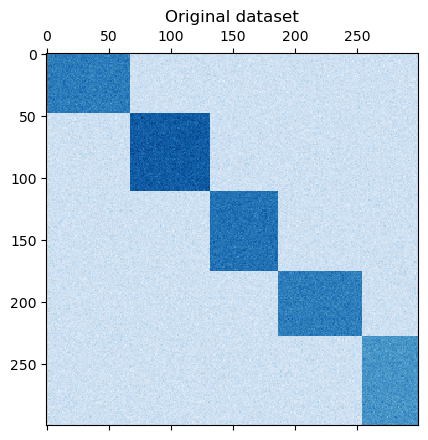

In [76]:
data, rows, columns = make_biclusters(
    shape=(300, 300), n_clusters=5, noise=5, shuffle=False, random_state=0
)

plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Original dataset")

In [78]:
type(data), data.shape

(numpy.ndarray, (300, 300))

Text(0.5, 1.0, 'Shuffled dataset')

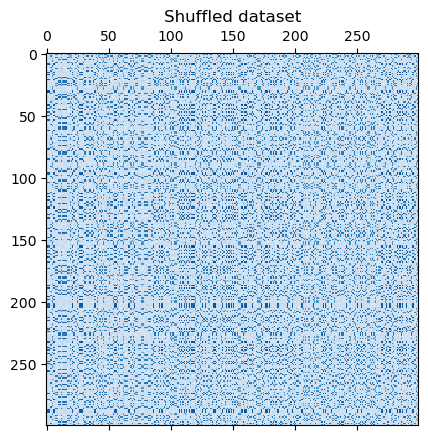

In [77]:

# shuffle clusters
rng = np.random.RandomState(0)
row_idx = rng.permutation(data.shape[0])
col_idx = rng.permutation(data.shape[1])
data = data[row_idx][:, col_idx]

plt.matshow(data, cmap=plt.cm.Blues)
plt.title("Shuffled dataset")

consensus score: 0.006


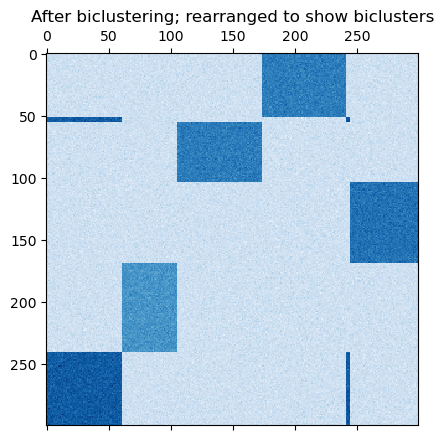

In [79]:

model = SpectralCoclustering(n_clusters=10, random_state=0)
model.fit(data)
score = consensus_score(model.biclusters_, (rows[:, row_idx], columns[:, col_idx]))

print("consensus score: {:.3f}".format(score))

fit_data = data[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.Blues)
plt.title("After biclustering; rearranged to show biclusters")

plt.show()